In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor


import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

from helper_functions import *
from timeit import default_timer as timer
from tqdm import tqdm

import pandas as pd
import random

import torchmetrics, mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

2.1.0
0.16.0


In [2]:
if torch.backends.mps.is_available(): # MPS device acceleration [For Macbook M1]
    device= "mps"
elif torch.cuda.is_available(): # use GPU, if exists
    device = "cuda"
else:
    device = "cpu"
print(device)

mps


In [3]:
def set_seed(seed):
    if device == "mps":
        torch.mps.manual_seed(seed)
    elif device == "cuda":
        torch.cuda.manual_seed(seed)
    else:
        torch.manual_seed(seed)

def print_train_time(start:float,
                     end:float,
                     device: torch.device=None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn, 
               device):
    """returns a dict containing the results of model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y) 
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # compare label
        # calculate the average
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return { 
                "model_name": model.__class__.__name__,
                "model_loss": loss.item(),
                "model_acc": acc
           }

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """performs a training with model trying to learn on data_loader"""
    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y= X.to(device), y.to(device)
        y_pred = model(X) # forward pass

        # get loss and accuracy
        loss = loss_fn(y_pred, y)
        train_loss += loss 
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        optimizer.zero_grad() # optimzer zero grad
        loss.backward() # loss backward
        optimizer.step() # update parameters

    # average training loss per batch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device):
    """performs a testing loop step on model going over dataloader"""
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y) 
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # compare label
            
        # calculate the average
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Train acc: {test_acc:.2f}%")

In [4]:
# get dataset - Fashion MNIST

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=False, # use True if it is first time
    transform=torchvision.transforms.ToTensor(), # pixel value range: [0, 1]; shape; (C x H x W)
    target_transform=None,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False, # use True if it is first time,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
)

### Common Function Usage

In [5]:
len(train_data), len(test_data)

(60000, 10000)

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
image, label = train_data[0]
image.shape, class_names[label]

(torch.Size([1, 28, 28]), 'Ankle boot')

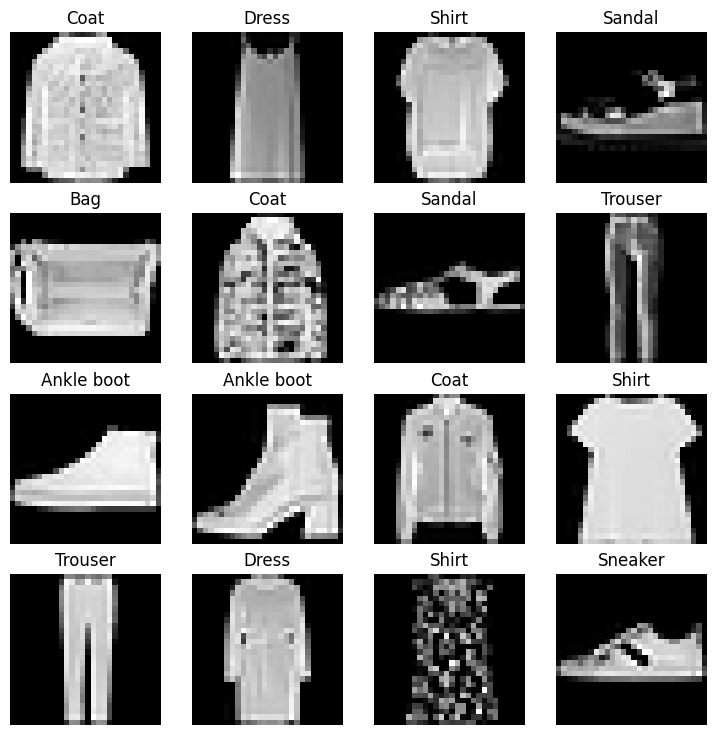

In [10]:
set_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    ridx = torch.randint(0, len(train_data), size=[1]).item()
    img, lbl = train_data[ridx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray") # important, we need to reduce the dimension by calling squeeze()
    plt.title(class_names[lbl])
    plt.axis(False)

### Break Data Into Batches

In [11]:
batch_size = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False) # test data, don't need to shuffle

print(f"len of train_dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"len of test_dataloader: {len(test_dataloader)} batches of {batch_size}")

len of train_dataloader: 1875 batches of 32
len of test_dataloader: 313 batches of 32


image size: torch.Size([1, 28, 28])


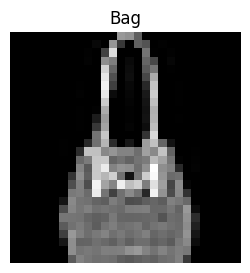

In [12]:
# show sample
train_features_batch, train_labels_batch = next(iter(train_dataloader)) 

# torch.manual_seed(1234)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
fig = plt.figure(figsize=(3, 3))
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"image size: {img.shape}")

### Baseline Model - Simple NN

In [13]:
# show what is Flatten()
flatten_model = nn.Flatten()

x = train_features_batch[0]
output = flatten_model(x) # forward pass

print(f"Shape before flattening: {x.shape} > [color channel, height, width]")
print(f"Shape after flattening: {output.shape} > [color channel, height * width]")

Shape before flattening: torch.Size([1, 28, 28]) > [color channel, height, width]
Shape after flattening: torch.Size([1, 784]) > [color channel, height * width]


In [14]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                    input_shape: int,
                    hidden_units: int,
                    output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                        in_features=input_shape,
                        out_features=hidden_units
                     ),
            nn.Linear(
                        in_features=hidden_units,
                        out_features=output_shape
                     )
        )
    def forward(self, x):
        return self.layer_stack(x)

model_0 = FashionMNISTModelV0(
    input_shape =784,
    hidden_units = 10,
    output_shape=len(class_names)
).to(device)

# set up loss, optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [15]:
# train baseline model
start_time = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")
    # training
    train_loss = 0
    # loop the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        X, y= X.to(device), y.to(device)
        model_0.train()
        # forward pass
        y_pred = model_0(X)
        # calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # add the loss of each batch
        # optimizer zero grad
        optimizer.zero_grad()
        # loss backward
        loss.backward()
        # optimizer step
        optimizer.step()
        if batch % 400 == 0: 
            print(f"{batch * len(X)} / {len(train_dataloader.dataset)} samples.")
    # average training loss per batch
    train_loss /= len(train_dataloader)

    # testing
    test_result = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn, device)
        
    print(f"Train loss: {train_loss:.4f} | Test loss: {test_result['model_loss']:.4f}, Test acc: {test_result['model_acc']:.4f}")

end_time = timer()
print_train_time(start_time, end_time, device=next(model_0.parameters()).device)

  0%|                                                                                                                  | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
0 / 60000 samples.
12800 / 60000 samples.
25600 / 60000 samples.
38400 / 60000 samples.
51200 / 60000 samples.


 33%|███████████████████████████████████▎                                                                      | 1/3 [00:08<00:16,  8.37s/it]

Train loss: 0.5892 | Test loss: 0.5713, Test acc: 79.7324
Epoch: 1
----
0 / 60000 samples.
12800 / 60000 samples.
25600 / 60000 samples.
38400 / 60000 samples.
51200 / 60000 samples.


 67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:15<00:07,  7.61s/it]

Train loss: 0.4773 | Test loss: 0.4749, Test acc: 83.5164
Epoch: 2
----
0 / 60000 samples.
12800 / 60000 samples.
25600 / 60000 samples.
38400 / 60000 samples.
51200 / 60000 samples.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:22<00:00,  7.54s/it]

Train loss: 0.4539 | Test loss: 0.5088, Test acc: 82.0487
Train time on mps:0: 22.642 seconds


22.642317000078037

In [16]:
model_0_result = eval_model(model_0,
                            test_dataloader,
                            loss_fn,
                            accuracy_fn,
                            device)

model_0_result

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5087789297103882,
 'model_acc': 82.04872204472844}

### Better Model - NN with non-linear layer
- using ReLU

In [17]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                    input_shape: int,
                    hidden_units: int,
                    output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                        in_features=input_shape,
                        out_features=hidden_units
                     ),
            nn.ReLU(),
            nn.Linear(
                        in_features=hidden_units,
                        out_features=output_shape
                     ),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layer_stack(x)

model_1 = FashionMNISTModelV1(
    input_shape =784,
    hidden_units = 10,
    output_shape=len(class_names)
).to(device)

# set up loss, optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


In [18]:
# train baseline model
start_time = timer()

epochs = 1
set_seed(1234)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")
    # training
    train_step(model_1, train_dataloader, loss_fn, optimizer, accuracy_fn, device)

    # testing
    test_step(model_1, test_dataloader, loss_fn, accuracy_fn, device)


end_time = timer()
_ = print_train_time(start_time, end_time, device=next(model_1.parameters()).device)

  0%|                                                                                                                  | 0/1 [00:00<?, ?it/s]

Epoch: 0
----
Train loss: 0.63273 | Train acc: 77.73%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]

Test loss: 0.60077 | Train acc: 78.98%
Train time on mps:0: 8.258 seconds


In [19]:
model_1_result = eval_model(model_1,
                            test_dataloader,
                            loss_fn,
                            accuracy_fn,
                            device)

model_1_result

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6007727384567261,
 'model_acc': 78.98362619808307}

### CNN
- TinyVGG

In [20]:
class FashionMNISTModelV2(nn.Module):
    """
        model architecture that replicate TinyVGG
    """
    def __init__(self,
                    input_shape: int,
                    hidden_units: int,
                    output_shape: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                    ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1
                    ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1
                    ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1
                    ),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units*7*7,
                       out_features= output_shape
                     )
        )
        
        
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

model_2 = FashionMNISTModelV2(
    input_shape =1, # black and white; 1 channel
    hidden_units = 10,
    output_shape=len(class_names)
).to(device)

# set up loss, optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)


In [21]:
# train baseline model
start_time = timer()

epochs = 3
set_seed(1234)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----")
    # training
    train_step(model_2, train_dataloader, loss_fn, optimizer, accuracy_fn, device)

    # testing
    test_step(model_2, test_dataloader, loss_fn, accuracy_fn, device)


end_time = timer()
_ = print_train_time(start_time, end_time, device=next(model_2.parameters()).device)

  0%|                                                                                                                  | 0/3 [00:00<?, ?it/s]

Epoch: 0
----
Train loss: 0.68984 | Train acc: 74.70%


 33%|███████████████████████████████████▎                                                                      | 1/3 [00:11<00:22, 11.33s/it]

Test loss: 0.39942 | Train acc: 85.85%
Epoch: 1
----
Train loss: 0.37024 | Train acc: 86.55%


 67%|██████████████████████████████████████████████████████████████████████▋                                   | 2/3 [00:22<00:10, 10.99s/it]

Test loss: 0.36615 | Train acc: 86.76%
Epoch: 2
----
Train loss: 0.33259 | Train acc: 87.88%


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.60s/it]

Test loss: 0.32995 | Train acc: 87.98%
Train time on mps:0: 31.793 seconds


In [22]:
model_2_result = eval_model(model_2,
                            test_dataloader,
                            loss_fn,
                            accuracy_fn,
                            device)

model_2_result

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3299485743045807,
 'model_acc': 87.97923322683707}

### Result Comparsion

Text(0, 0.5, 'model')

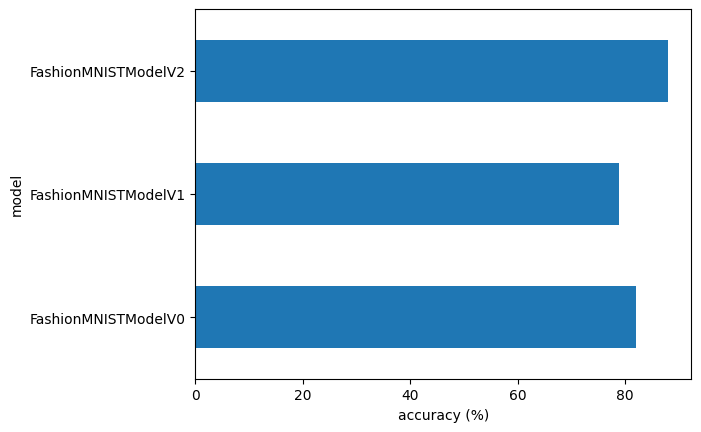

In [23]:
df_result = pd.DataFrame([
    model_0_result,
    model_1_result,
    model_2_result,
])

df_result.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

### Make Prediction

In [24]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [25]:
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs = make_predictions(model_2, test_samples, device)

pred_classes = pred_probs.argmax(dim=1)

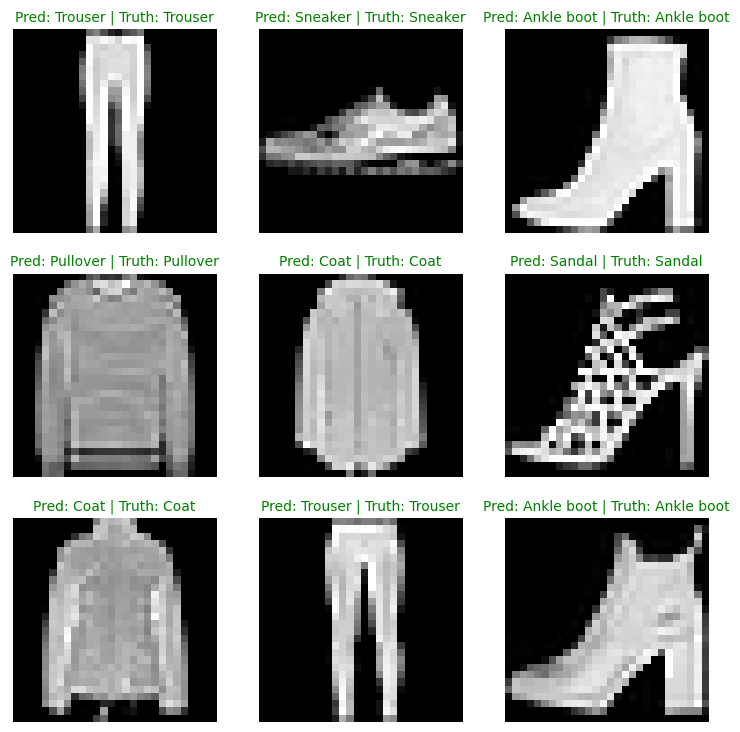

In [26]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")

    pred_label = class_names[pred_classes[i]]
    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]] 
    
    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);


### Confusion Matrix

In [27]:
# predict all test data

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|█████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 242.81it/s]


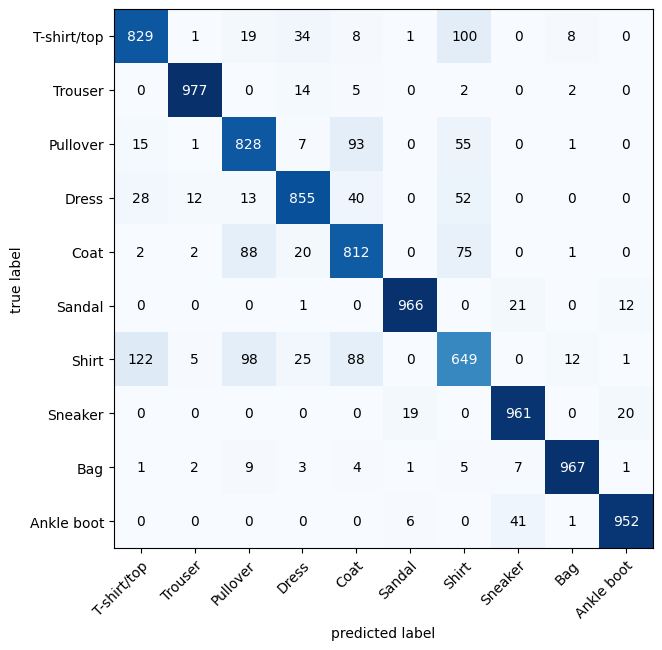

In [28]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=class_names,
    figsize=(10, 7)
);

### Save / Load Model

In [29]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True,
                 exist_ok=True
)

model_name = "03_CNN_model.pth"
model_save_path = model_path / model_name

#save
print(f"Saving model to: {model_save_path}")
torch.save(obj=model_2.state_dict(), 
           f=model_save_path)

Saving model to: models/03_CNN_model.pth


In [30]:
# create the instance of FashionMNISTModelV2
loaded_model_2 = FashionMNISTModelV2(input_shape=1, 
                                    hidden_units=10,
                                    output_shape=10) 
# load model state from file 
loaded_model_2.load_state_dict(torch.load(f=model_save_path))
loaded_model_2 = loaded_model_2.to(device)

In [31]:
# evaluate
loaded_model_2_result = eval_model(
    loaded_model_2,
    test_dataloader,
    loss_fn, 
    accuracy_fn,device)
loaded_model_2_result

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3299485743045807,
 'model_acc': 87.97923322683707}

In [32]:
# double check if the model prediction result are the same
torch.isclose(torch.tensor(model_2_result["model_loss"]), 
              torch.tensor(loaded_model_2_result["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)